In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.regression.quantile_regression import QuantReg

In [2]:
# Baca file CSV
file_path = '/run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rain0n90e_dy.csv'
df = pd.read_csv(file_path)
print(f"Memproses data untuk file {file_path}...")

Memproses data untuk file /run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rain0n90e_dy.csv...


In [3]:
# Konversi Date dan set sebagai indeks
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [4]:
df.head(5)

,Year,Month,Day,Prec,StDev,%Time,Q,S
Date,,,,,,,,
2005-01-01,2005,Januari,1,0.36,1.20,9.7,2,5
2005-01-02,2005,Januari,2,0.19,0.46,6.9,2,5
2005-01-03,2005,Januari,3,0.00,0.01,0.0,2,5
2005-01-04,2005,Januari,4,0.13,1.13,1.4,2,5
2005-01-05,2005,Januari,5,0.95,3.48,10.4,2,5


In [5]:
# 1. Penanganan Missing Values
print("\n--- LANGKAH 1: PENANGANAN MISSING VALUES ---")
before_cleaning = df.isna().sum()
print(f"Missing values sebelum cleaning:\n{before_cleaning}")



--- LANGKAH 1: PENANGANAN MISSING VALUES ---
Missing values sebelum cleaning:
Year      0
Month     0
Day       0
Prec     81
StDev     5
%Time     5
Q         0
S         0
dtype: int64


In [6]:
# Handle missing values berdasarkan Quality Code
def handle_missing_rainfall(row):
    if pd.isna(row['Prec']):
        return 0
    return row['Q']
    

In [7]:
# Update Quality Code untuk data yang hilang
df['Q'] = df.apply(handle_missing_rainfall, axis=1)
df['Q'] = df['Q'].astype(int)
df['S'] = df['S'].astype(int)
print(f"Missing values setelah penanganan awal:\n{df.isna().sum()}")



Missing values setelah penanganan awal:
Year      0
Month     0
Day       0
Prec     81
StDev     5
%Time     5
Q         0
S         0
dtype: int64


In [8]:
# 2. Filtering Data Berdasarkan Quality dan Source Codes
print("\n--- LANGKAH 2: FILTERING BERDASARKAN QUALITY & SOURCE CODES ---")
print(f"Distribusi Quality Code (Q):\n{df['Q'].value_counts().sort_index()}")
print(f"Distribusi Source Code (S):\n{df['S'].value_counts().sort_index()}")



--- LANGKAH 2: FILTERING BERDASARKAN QUALITY & SOURCE CODES ---
Distribusi Quality Code (Q):
Q
0      81
1    1055
2    2139
Name: count, dtype: int64
Distribusi Source Code (S):
S
0       4
1    1520
5    1751
Name: count, dtype: int64


In [9]:
# Buat copy data untuk proses cleaning
df_clean = df.copy()

In [10]:
# Filter out data dengan Q=0 (datum missing) dan Q=5 (sensor failed)
df_clean = df_clean[~df_clean['Q'].isin([0, 5])]
print(f"Menghapus {len(df) - len(df_clean)} baris dengan Q=0 atau Q=5")

Menghapus 81 baris dengan Q=0 atau Q=5


In [11]:
# Prioritaskan data berdasarkan Source Code
def prioritize_source(group):
    if len(group) == 1:
        return group
    if 5 in group['S'].values:
        return group[group['S'] == 5].iloc[0:1]
    elif 1 in group['S'].values:
        return group[group['S'] == 1].iloc[0:1]
    else:
        return group.iloc[0:1]


In [12]:
# Check for duplicate timestamps
if df_clean.index.duplicated().any():
    print(f"Ditemukan {df_clean.index.duplicated().sum()} timestamp duplikat")
    df_clean = df_clean.groupby(level=0).apply(prioritize_source)
    df_clean = df_clean.droplevel(1) if df_clean.index.nlevels > 1 else df_clean
else:
    print("Tidak ditemukan date atau timestamp duplikat")

Tidak ditemukan date atau timestamp duplikat


In [13]:
# 3. Deteksi dan Penanganan Outliers
print("\n--- LANGKAH 3: DETEKSI DAN PENANGANAN OUTLIERS ---")

def detect_rainfall_outliers(df):
    # Deteksi outliers menggunakan multiple criteria
    
    # 1. Physical constraints
    physical_outliers = (df['Prec'] < 0) | (df['Prec'] > 500)  # 500mm/day adalah curah hujan ekstrem
    
    # 2. Statistical outliers (Modified Z-score untuk data skewed)
    median = df['Prec'].median()
    mad = stats.median_abs_deviation(df['Prec'])
    modified_z_scores = 0.6745 * (df['Prec'] - median) / mad
    statistical_outliers = np.abs(modified_z_scores) > 3.5
    
    # 3. Consistency check dengan %Time
    time_inconsistent = (df['Prec'] > 0) & (df['%Time'] == 0)
    
    return physical_outliers | statistical_outliers | time_inconsistent


--- LANGKAH 3: DETEKSI DAN PENANGANAN OUTLIERS ---


In [14]:

# Terapkan deteksi outliers
outliers = detect_rainfall_outliers(df_clean)
outlier_count = outliers.sum()
print(f"Terdeteksi {outlier_count} outliers ({outlier_count/len(df_clean)*100:.2f}% dari data)")

Terdeteksi 1666 outliers (52.16% dari data)


In [15]:
# Update Quality Code untuk outliers
df_clean.loc[outliers & ~df_clean['Q'].isin([3, 4]), 'Q'] = 4

In [16]:
# 4. Quantile Regression Smoothing
print("\n--- LANGKAH 4: QUANTILE REGRESSION SMOOTHING ---")

def apply_quantile_smoothing(data, tau=0.5, window=30):
    # Buat array time index
    time_idx = np.arange(len(data))
    
    # Inisialisasi array untuk hasil smoothing
    smoothed = np.zeros(len(data))
    
    # Aplikasikan quantile regression dengan rolling window
    for i in range(len(data)):
        start_idx = max(0, i - window//2)
        end_idx = min(len(data), i + window//2)
        
        window_data = data.iloc[start_idx:end_idx]
        window_time = time_idx[start_idx:end_idx]
        
        if len(window_data) > 5:  # Minimal 5 point untuk fitting
            model = QuantReg(window_data, window_time - window_time[0])
            results = model.fit(q=tau)
            smoothed[i] = results.predict([time_idx[i] - window_time[0]])[0]
        else:
            smoothed[i] = data.iloc[i]
    
    return smoothed


--- LANGKAH 4: QUANTILE REGRESSION SMOOTHING ---


In [17]:
# Terapkan smoothing hanya pada data valid (Q=1 atau Q=2)
valid_mask = df_clean['Q'].isin([1, 2])
df_clean['Prec_Smoothed'] = np.nan

if valid_mask.sum() > 0:
    try:
        smoothed_values = apply_quantile_smoothing(df_clean.loc[valid_mask, 'Prec'])
        df_clean.loc[valid_mask, 'Prec_Smoothed'] = smoothed_values
        print("Quantile regression smoothing berhasil diterapkan")
    except Exception as e:
        print(f"Gagal menerapkan quantile regression smoothing: {e}")


/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in scalar divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: invalid value encountered in divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/home/cryptedlm/python-venv/tugas-akhir/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


Quantile regression smoothing berhasil diterapkan


In [18]:
# 5. Visualisasi Hasil
print("\n--- LANGKAH 5: VISUALISASI HASIL ---")

plt.figure(figsize=(15, 10))


--- LANGKAH 5: VISUALISASI HASIL ---


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

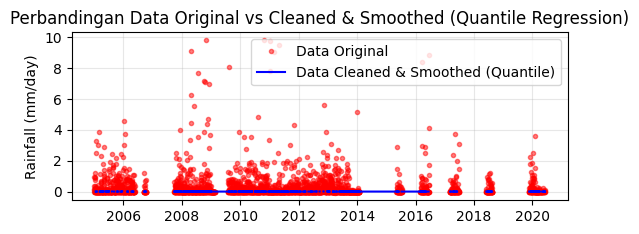

In [19]:
# Plot 1: Data asli vs Data bersih
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Prec'], 'r.', alpha=0.5, label='Data Original')
plt.plot(df_clean.index, df_clean['Prec_Smoothed'], 'b-', label='Data Cleaned & Smoothed (Quantile)')
plt.legend()
plt.title('Perbandingan Data Original vs Cleaned & Smoothed (Quantile Regression)')
plt.ylabel('Rainfall (mm/day)')
plt.grid(True, alpha=0.3)

Text(0, 0.5, 'Jumlah Data')

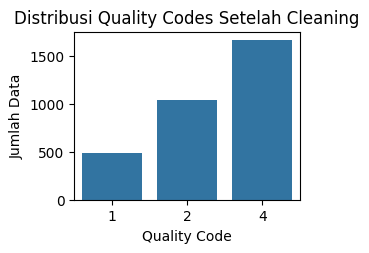

In [20]:
# Plot 2: Distribusi Quality Codes setelah cleaning
plt.subplot(2, 2, 3)
sns.countplot(x='Q', data=df_clean)
plt.title('Distribusi Quality Codes Setelah Cleaning')
plt.xlabel('Quality Code')
plt.ylabel('Jumlah Data')

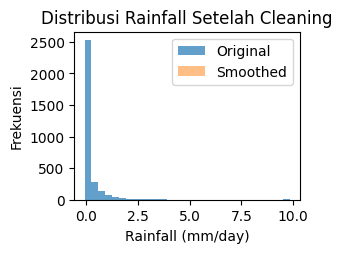

In [21]:

# Plot 3: Histogram data setelah cleaning
plt.subplot(2, 2, 4)
plt.hist(df_clean['Prec'], bins=30, alpha=0.7, label='Original')
plt.hist(df_clean['Prec_Smoothed'].dropna(), bins=30, alpha=0.5, label='Smoothed')
plt.title('Distribusi Rainfall Setelah Cleaning')
plt.xlabel('Rainfall (mm/day)')
plt.ylabel('Frekuensi')
plt.legend()

In [22]:
plt.tight_layout()
plt.savefig('rainfall_data_cleaning_results.png')
print("Visualisasi disimpan sebagai 'rainfall_data_cleaning_results.png'")

Visualisasi disimpan sebagai 'rainfall_data_cleaning_results.png'


<Figure size 640x480 with 0 Axes>

In [23]:
# 6. Statistik Hasil
print("\n--- LANGKAH 6: STATISTIK HASIL CLEANING ---")
print(f"Jumlah data original: {len(df)}")
print(f"Jumlah data setelah cleaning: {len(df_clean)}")
print(f"Persentase data yang dipertahankan: {len(df_clean)/len(df)*100:.2f}%")



--- LANGKAH 6: STATISTIK HASIL CLEANING ---
Jumlah data original: 3275
Jumlah data setelah cleaning: 3194
Persentase data yang dipertahankan: 97.53%


In [24]:

print("\nStatistik Data Original:")
print(df['Prec'].describe())



Statistik Data Original:
count    3194.000000
mean        0.252070
std         0.782724
min        -0.070000
25%         0.000000
50%         0.000000
75%         0.160000
max         9.830000
Name: Prec, dtype: float64


In [25]:
print("\nStatistik Data Cleaned & Smoothed:")
print(df_clean['Prec_Smoothed'].describe())



Statistik Data Cleaned & Smoothed:
count    1.528000e+03
mean     4.405767e-04
std      1.892619e-03
min      0.000000e+00
25%      1.690190e-07
50%      1.176621e-06
75%      4.702801e-06
max      1.499776e-02
Name: Prec_Smoothed, dtype: float64


In [26]:
# 7. Simpan hasil ke file Excel
output_xlsx = file_path.replace('.csv', '_cleaned.xlsx')

with pd.ExcelWriter(output_xlsx, engine='xlsxwriter') as writer:
    df_clean.to_excel(writer, sheet_name='Cleaned Data')
    
    workbook = writer.book
    worksheet = writer.sheets['Cleaned Data']
    
    for idx, col in enumerate(df_clean.columns):
        max_len = max(df_clean[col].astype(str).map(len).max(), len(col)) + 2
        worksheet.set_column(idx, idx, max_len)

print(f"Hasil preprocessing disimpan dalam file '{output_xlsx}'")

Hasil preprocessing disimpan dalam file '/run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rain0n90e_dy_cleaned.xlsx'


In [27]:
# Tampilkan informasi akhir
print("\n--- RINGKASAN PROSES CLEANING ---")
print(f"1. {len(df) - len(df_clean)} baris data difilter keluar")
print(f"2. {outlier_count} outliers ditandai dengan Quality Code = 4")
print(f"3. Quantile Regression smoothing diterapkan pada data valid")
print(f"4. Hasil disimpan sebagai Excel dan visualisasi")



--- RINGKASAN PROSES CLEANING ---
1. 81 baris data difilter keluar
2. 1666 outliers ditandai dengan Quality Code = 4
3. Quantile Regression smoothing diterapkan pada data valid
4. Hasil disimpan sebagai Excel dan visualisasi
